<a href="https://colab.research.google.com/github/ZiadMotagaly/facenet/blob/main/facenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [ ]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.cuda.is_available()

True

In [ ]:
PATH = '/content/drive/My Drive/ColabNotebooks/att_face_dataset/att_face_dataset/'

**ATT Dataset**

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=transforms.ToTensor()):
        self.dirs = glob.glob(f'{path}*/')
        self.transform = transform

        self.total_images = self._get_images(self.dirs, self.transform)

    def _get_images(self, dirs, transform):
        ti = []
        for dir in tqdm(dirs):
#             images = [transform(Image.open(image)).squeeze() for image in glob.glob(f'{dir}*')]
            images = [transform(Image.open(image)) for image in glob.glob(f'{dir}*')]
            ti.append(images)
        return ti

    def __len__(self):
        return self.dirs.__len__()

    def __getitem__(self,idx):
        return torch.stack(self.total_images[idx], dim=0)
# ref : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
att_dataset = CustomDataset(PATH)

100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


In [ ]:
len(att_dataset)


40

In [ ]:
att_dataset

In [ ]:
att_dataset[0].shape

torch.Size([10, 1, 112, 92])

In [ ]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [ ]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()

# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [ ]:
def get_random_triplets(embeddings,  targets=None) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets.
    '''


#     assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)

In [ ]:
dataset = list(att_dataset)


In [ ]:
train = dataset[0:30]


In [ ]:
len(train)


30

In [ ]:
test = dataset[30:]


In [ ]:
len(test)


10

In [ ]:
triplets = get_random_triplets(train)


In [ ]:
triplets.shape


torch.Size([8700, 3, 1, 112, 92])

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,3))),
                            ('norm', nn.BatchNorm2d(32)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(64)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(128)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.conv     = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)

        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=3072, out_features=1024)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=1024, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            # ('relu3', nn.ReLU(inplace=True)),
        ]))


        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = self.conv(x)
        x = x.view(-1, 6*4*128)
        # x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [ ]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(1, 16, kernel_size=(7, 5), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(5, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): Re

In [ ]:
with torch.no_grad():
    x = model.semi_forward(att_dataset)
    print(att_dataset.shape)
    print(x[0])

    y = model.semi_forward(att_dataset[0].unsqueeze(0))
    print(att_dataset[0].unsqueeze(0).shape)
    print(y)

    print((att_dataset[0].unsqueeze(0) == att_dataset[0]).sum())
    (x == y).sum()

TypeError: ignored

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

4170400

In [ ]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
cost = []
train_acc = []
test_acc = []
epochs = 15
for epoch in range(epochs):

    triplets = get_random_triplets(train)
    loader = DataLoader(triplets, batch_size=500)
    for i,batch in enumerate(loader):
        if torch.cuda.is_available():
            apn = model(batch.cuda())
        else:
            apn = model(batch)

        optimizer.zero_grad()
        loss = triplet_loss(*apn)
        # loss = lossfn(*apn)
        cost.append(loss.item())

        loss.backward()
        optimizer.step()

        ####
        # sample = torch.cat([model.semi_forward(att_dataset[i][0].unsqueeze(0).cuda()) for i in range(40)])
        # total_enc = [model.semi_forward(img.cuda()) for img in dataset]
        # pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
        # acc1 = sum([(pred[i] == i).sum() for i in range(0,30)]) / 300
        # acc2 = sum([(pred[i] == i).sum() for i in range(30,40)]) / 100
        # train_acc.append(acc1)
        # test_acc.append(acc2)
        ####

        if i%20==0 :
            # print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/87]', 'Cost : {:.2f}, Train Acc: {:.2f}, Test Acc: {:.2f}'.format(loss.item(), acc1, acc2))
            print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/] Cost : {loss.item()}')

Epoch:[1/15], Step:[1/] Cost : 0.1013384759426117
Epoch:[2/15], Step:[1/] Cost : 0.022036762908101082
Epoch:[3/15], Step:[1/] Cost : 0.025683056563138962
Epoch:[4/15], Step:[1/] Cost : 0.010993736796081066
Epoch:[5/15], Step:[1/] Cost : 0.008536777459084988
Epoch:[6/15], Step:[1/] Cost : 0.002934434451162815
Epoch:[7/15], Step:[1/] Cost : 0.0007567564607597888
Epoch:[8/15], Step:[1/] Cost : 0.0024686199612915516
Epoch:[9/15], Step:[1/] Cost : 0.0010674004442989826
Epoch:[10/15], Step:[1/] Cost : 0.0007982022943906486
Epoch:[11/15], Step:[1/] Cost : 0.00036782657844014466
Epoch:[12/15], Step:[1/] Cost : 0.00038989612949080765
Epoch:[13/15], Step:[1/] Cost : 0.0008638770086690784
Epoch:[14/15], Step:[1/] Cost : 0.00015690512373112142
Epoch:[15/15], Step:[1/] Cost : 5.4578573326580226e-05


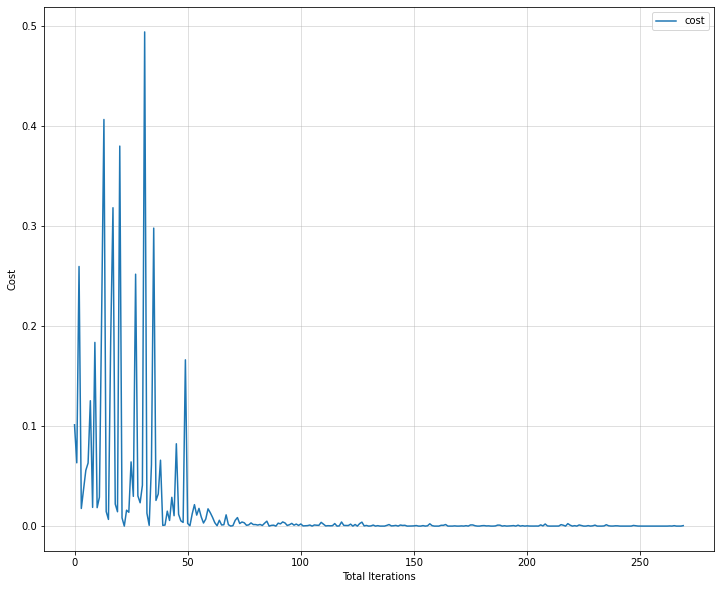

In [ ]:
plt.figure(figsize=(12,10))
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(len(cost)), cost, label='cost')
# plt.plot(np.arange(len(train_acc)), train_acc, label='train_acc')
# plt.plot(np.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid(alpha=0.5)
plt.legend()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/siamese-orl-loss on 30classes')
plt.show()

In [ ]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
n = (apn[0] - apn[2]).pow(2).sum(-1)

In [ ]:
p.max() , p.mean() , n.max(), n.mean()


(tensor(1.4231, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.8647, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(7.3217, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(3.6133, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
sample = torch.cat([model.semi_forward(dataset[i][0].unsqueeze(0).cuda()) for i in tqdm(range(40))])


100%|██████████| 40/40 [00:00<00:00, 874.40it/s]


In [ ]:
sample.device


device(type='cuda', index=0)

In [ ]:
sample.shape


torch.Size([40, 128])

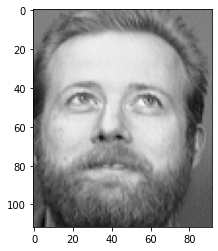

In [ ]:
Class = 0
randImg = dataset[Class][0]
plt.imshow(randImg.squeeze(), cmap='gray')
renc = model.semi_forward(randImg.unsqueeze(0).cuda())

In [ ]:
dis = dist(renc, sample)
dis.argmin(), dis

(tensor(0, device='cuda:0'),
 tensor([0.0000, 2.4852, 5.5270, 1.8431, 3.0656, 2.3418, 1.2660, 1.8373, 1.8809,
         1.3492, 4.8949, 2.2838, 2.6625, 5.1208, 2.6684, 1.6107, 3.4180, 3.6100,
         2.4952, 2.0669, 4.9787, 1.1611, 2.1805, 4.6542, 4.1450, 3.9852, 4.3040,
         2.1565, 3.0525, 2.9782, 2.4489, 1.6495, 2.6570, 1.9603, 1.3391, 2.6215,
         2.7621, 2.2655, 6.1738, 1.0774], device='cuda:0'))

In [ ]:
renc


tensor([[ 0.1448, -0.0399, -0.5426,  0.0916,  0.2374, -0.3261, -0.4788, -0.0273,
         -0.7106,  0.2707,  0.8042, -0.3076, -0.4545,  0.1558, -0.2263,  0.0270,
         -0.4494,  0.4184,  0.2964, -0.1096,  0.2609, -0.2009,  0.1485, -0.7664,
         -0.3512,  0.1075,  0.2969, -0.0733,  0.1780, -0.2396,  0.0896,  0.4529,
         -0.5653,  0.4935,  0.0040, -0.4337, -0.4841, -0.1890,  0.4240,  0.1784,
          0.1031,  0.2777,  0.1792,  0.0376, -0.1993, -0.5251,  0.3861,  0.2203,
         -0.4577, -0.3200,  0.1832,  0.1937, -0.0062,  0.0906,  0.6730,  0.1465,
         -0.1673,  0.3216,  0.1639,  0.5662, -0.2152, -0.0341,  0.0590,  0.3524,
          0.5156, -0.4711,  0.0957, -0.4234,  0.2156,  0.2359,  0.3063,  0.1152,
          1.2758,  0.1220,  0.1210, -0.1754, -0.5689,  0.4966, -0.2213,  0.4086,
         -0.1332,  0.2767, -0.6595,  0.0866,  0.0851, -0.2307, -0.4585,  0.2522,
         -0.2240,  0.1882, -0.0840, -0.2600,  0.0712, -0.7458,  0.1871, -0.2566,
         -0.3060, -0.2350, -

In [ ]:
sample[0]


tensor([ 0.1448, -0.0399, -0.5426,  0.0916,  0.2374, -0.3261, -0.4788, -0.0273,
        -0.7106,  0.2707,  0.8042, -0.3076, -0.4545,  0.1558, -0.2263,  0.0270,
        -0.4494,  0.4184,  0.2964, -0.1096,  0.2609, -0.2009,  0.1485, -0.7664,
        -0.3512,  0.1075,  0.2969, -0.0733,  0.1780, -0.2396,  0.0896,  0.4529,
        -0.5653,  0.4935,  0.0040, -0.4337, -0.4841, -0.1890,  0.4240,  0.1784,
         0.1031,  0.2777,  0.1792,  0.0376, -0.1993, -0.5251,  0.3861,  0.2203,
        -0.4577, -0.3200,  0.1832,  0.1937, -0.0062,  0.0906,  0.6730,  0.1465,
        -0.1673,  0.3216,  0.1639,  0.5662, -0.2152, -0.0341,  0.0590,  0.3524,
         0.5156, -0.4711,  0.0957, -0.4234,  0.2156,  0.2359,  0.3063,  0.1152,
         1.2758,  0.1220,  0.1210, -0.1754, -0.5689,  0.4966, -0.2213,  0.4086,
        -0.1332,  0.2767, -0.6595,  0.0866,  0.0851, -0.2307, -0.4585,  0.2522,
        -0.2240,  0.1882, -0.0840, -0.2600,  0.0712, -0.7458,  0.1871, -0.2566,
        -0.3060, -0.2350, -0.0726, -0.08

In [ ]:
model.semi_forward(dataset[0][0].unsqueeze(0).cuda())


tensor([[ 0.1448, -0.0399, -0.5426,  0.0916,  0.2374, -0.3261, -0.4788, -0.0273,
         -0.7106,  0.2707,  0.8042, -0.3076, -0.4545,  0.1558, -0.2263,  0.0270,
         -0.4494,  0.4184,  0.2964, -0.1096,  0.2609, -0.2009,  0.1485, -0.7664,
         -0.3512,  0.1075,  0.2969, -0.0733,  0.1780, -0.2396,  0.0896,  0.4529,
         -0.5653,  0.4935,  0.0040, -0.4337, -0.4841, -0.1890,  0.4240,  0.1784,
          0.1031,  0.2777,  0.1792,  0.0376, -0.1993, -0.5251,  0.3861,  0.2203,
         -0.4577, -0.3200,  0.1832,  0.1937, -0.0062,  0.0906,  0.6730,  0.1465,
         -0.1673,  0.3216,  0.1639,  0.5662, -0.2152, -0.0341,  0.0590,  0.3524,
          0.5156, -0.4711,  0.0957, -0.4234,  0.2156,  0.2359,  0.3063,  0.1152,
          1.2758,  0.1220,  0.1210, -0.1754, -0.5689,  0.4966, -0.2213,  0.4086,
         -0.1332,  0.2767, -0.6595,  0.0866,  0.0851, -0.2307, -0.4585,  0.2522,
         -0.2240,  0.1882, -0.0840, -0.2600,  0.0712, -0.7458,  0.1871, -0.2566,
         -0.3060, -0.2350, -

In [ ]:
model.semi_forward(dataset[0].cuda())[0]


tensor([ 0.0990, -0.0656, -0.5216,  0.0893,  0.3054, -0.3207, -0.4283, -0.0439,
        -0.6599,  0.2642,  0.7645, -0.2556, -0.4409,  0.1833, -0.2206,  0.0608,
        -0.3695,  0.4170,  0.2920, -0.1149,  0.3234, -0.1763,  0.1087, -0.6943,
        -0.3557,  0.0838,  0.2669, -0.0606,  0.1957, -0.2395,  0.0755,  0.4050,
        -0.5374,  0.4696, -0.0072, -0.4600, -0.4399, -0.1582,  0.3977,  0.2066,
         0.0327,  0.2107,  0.1701,  0.0496, -0.2357, -0.4884,  0.3157,  0.2243,
        -0.4825, -0.3090,  0.1519,  0.1729, -0.0112,  0.0555,  0.6401,  0.1452,
        -0.1559,  0.2669,  0.1675,  0.5993, -0.1999, -0.0643,  0.0521,  0.4112,
         0.4606, -0.4671,  0.1165, -0.4274,  0.1472,  0.2229,  0.2869,  0.0813,
         1.2140,  0.1154,  0.0958, -0.1668, -0.6180,  0.4908, -0.1860,  0.3495,
        -0.0640,  0.2953, -0.6725,  0.0767,  0.0950, -0.2475, -0.4634,  0.2136,
        -0.1991,  0.2051, -0.0626, -0.2362,  0.0792, -0.7086,  0.1776, -0.2701,
        -0.2701, -0.2346, -0.1097, -0.05

In [ ]:
total_enc = [model.semi_forward(dataset[i].cuda()) for i in tqdm(range(40))]


100%|██████████| 40/40 [00:00<00:00, 198.66it/s]


In [ ]:
total_enc[0][0]


tensor([ 0.0990, -0.0656, -0.5216,  0.0893,  0.3054, -0.3207, -0.4283, -0.0439,
        -0.6599,  0.2642,  0.7645, -0.2556, -0.4409,  0.1833, -0.2206,  0.0608,
        -0.3695,  0.4170,  0.2920, -0.1149,  0.3234, -0.1763,  0.1087, -0.6943,
        -0.3557,  0.0838,  0.2669, -0.0606,  0.1957, -0.2395,  0.0755,  0.4050,
        -0.5374,  0.4696, -0.0072, -0.4600, -0.4399, -0.1582,  0.3977,  0.2066,
         0.0327,  0.2107,  0.1701,  0.0496, -0.2357, -0.4884,  0.3157,  0.2243,
        -0.4825, -0.3090,  0.1519,  0.1729, -0.0112,  0.0555,  0.6401,  0.1452,
        -0.1559,  0.2669,  0.1675,  0.5993, -0.1999, -0.0643,  0.0521,  0.4112,
         0.4606, -0.4671,  0.1165, -0.4274,  0.1472,  0.2229,  0.2869,  0.0813,
         1.2140,  0.1154,  0.0958, -0.1668, -0.6180,  0.4908, -0.1860,  0.3495,
        -0.0640,  0.2953, -0.6725,  0.0767,  0.0950, -0.2475, -0.4634,  0.2136,
        -0.1991,  0.2051, -0.0626, -0.2362,  0.0792, -0.7086,  0.1776, -0.2701,
        -0.2701, -0.2346, -0.1097, -0.05

In [ ]:
pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
print(*pred, sep='\n')

tensor([0, 0, 9, 9, 0, 0, 9, 9, 9, 9], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([3, 9, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([ 4,  4,  4,  4,  4, 11,  4,  4,  4,  4], device='cuda:0')
tensor([ 5,  5,  5,  5,  5, 33, 32,  5,  5,  5], device='cuda:0')
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0')
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
tensor([10, 10, 20,  3, 10, 10, 10, 10, 10, 10], device='cuda:0')
tensor([11, 11, 33, 11, 11, 11, 11, 11, 11, 33], device='cuda:0')
tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12], device='cuda:0')
tensor([13, 20, 36, 13, 20, 13, 13, 20, 13, 20], device='cuda:0')
tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14], device='cuda:0')
tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15], device='cuda:0')
tensor([16, 14, 38, 16, 

In [ ]:
sum([(pred[i] == i).sum() for i in range(0,30)]) / 300


tensor(0.8533, device='cuda:0')

In [ ]:
tc = []
for i in range(0,40):
    corr = (pred[i] == i).sum()
    print(f'(Claas {i})', corr.item(), 'out of 10')
    tc.append(corr.item())

print('Train Accuracy = ', sum(tc[:30])/3, '%')
print('Test Accuracy = ', sum(tc[30:])/1, '%')
print('Total Accuracy = ', sum(tc)/4, '%')

(Claas 0) 4 out of 10
(Claas 1) 10 out of 10
(Claas 2) 10 out of 10
(Claas 3) 9 out of 10
(Claas 4) 9 out of 10
(Claas 5) 8 out of 10
(Claas 6) 10 out of 10
(Claas 7) 10 out of 10
(Claas 8) 10 out of 10
(Claas 9) 10 out of 10
(Claas 10) 8 out of 10
(Claas 11) 8 out of 10
(Claas 12) 10 out of 10
(Claas 13) 5 out of 10
(Claas 14) 10 out of 10
(Claas 15) 10 out of 10
(Claas 16) 4 out of 10
(Claas 17) 6 out of 10
(Claas 18) 7 out of 10
(Claas 19) 7 out of 10
(Claas 20) 9 out of 10
(Claas 21) 10 out of 10
(Claas 22) 5 out of 10
(Claas 23) 10 out of 10
(Claas 24) 9 out of 10
(Claas 25) 10 out of 10
(Claas 26) 10 out of 10
(Claas 27) 9 out of 10
(Claas 28) 9 out of 10
(Claas 29) 10 out of 10
(Claas 30) 8 out of 10
(Claas 31) 5 out of 10
(Claas 32) 10 out of 10
(Claas 33) 10 out of 10
(Claas 34) 7 out of 10
(Claas 35) 4 out of 10
(Claas 36) 7 out of 10
(Claas 37) 4 out of 10
(Claas 38) 6 out of 10
(Claas 39) 8 out of 10
Train Accuracy =  85.33333333333333 %
Test Accuracy =  69.0 %
Total Accura

In [ ]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
        if pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={pred[i][j].item()}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results of all 40 classes.png', dpi=200)
plt.show()

In [ ]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.cuda.is_available()

True

In [ ]:
PATH = '/content/drive/My Drive/ColabNotebooks/att_face_dataset/att_face_dataset/'

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=transforms.ToTensor()):
        self.dirs = glob.glob(f'{path}*/')
        self.transform = transform

        self.total_images = self._get_images(self.dirs, self.transform)

    def _get_images(self, dirs, transform):
        ti = []
        for dir in tqdm(dirs):
#             images = [transform(Image.open(image)).squeeze() for image in glob.glob(f'{dir}*')]
            images = [transform(Image.open(image)) for image in glob.glob(f'{dir}*')]
            ti.append(images)
        return ti

    def __len__(self):
        return self.dirs.__len__()

    def __getitem__(self,idx):
        return torch.stack(self.total_images[idx], dim=0)
# ref : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
att_dataset = CustomDataset(PATH)

100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


In [ ]:
len(att_dataset)


40

In [ ]:
att_dataset

In [ ]:
att_dataset[0].shape

torch.Size([10, 1, 112, 92])

In [ ]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [ ]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()

# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [ ]:
def get_random_triplets(embeddings,  targets=None) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets.
    '''


#     assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)

In [ ]:
dataset = list(att_dataset)


In [ ]:
train = dataset[0:30]


In [ ]:
len(train)


30

In [ ]:
test = dataset[30:]


In [ ]:
len(test)


10

In [ ]:
triplets = get_random_triplets(train)


In [ ]:
triplets.shape


torch.Size([8700, 3, 1, 112, 92])

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,3))),
                            ('norm', nn.BatchNorm2d(32)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(64)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(128)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.conv     = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)

        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=3072, out_features=1024)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=1024, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            # ('relu3', nn.ReLU(inplace=True)),
        ]))


        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = self.conv(x)
        x = x.view(-1, 6*4*128)
        # x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [ ]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(1, 16, kernel_size=(7, 5), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(5, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): Re

In [ ]:
with torch.no_grad():
    x = model.semi_forward(att_dataset)
    print(att_dataset.shape)
    print(x[0])

    y = model.semi_forward(att_dataset[0].unsqueeze(0))
    print(att_dataset[0].unsqueeze(0).shape)
    print(y)

    print((att_dataset[0].unsqueeze(0) == att_dataset[0]).sum())
    (x == y).sum()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

4170400

In [ ]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
cost = []
train_acc = []
test_acc = []
epochs = 15
for epoch in range(epochs):

    triplets = get_random_triplets(train)
    loader = DataLoader(triplets, batch_size=500)
    for i,batch in enumerate(loader):
        if torch.cuda.is_available():
            apn = model(batch.cuda())
        else:
            apn = model(batch)

        optimizer.zero_grad()
        loss = triplet_loss(*apn)
        # loss = lossfn(*apn)
        cost.append(loss.item())

        loss.backward()
        optimizer.step()

        ####
        # sample = torch.cat([model.semi_forward(att_dataset[i][0].unsqueeze(0).cuda()) for i in range(40)])
        # total_enc = [model.semi_forward(img.cuda()) for img in dataset]
        # pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
        # acc1 = sum([(pred[i] == i).sum() for i in range(0,30)]) / 300
        # acc2 = sum([(pred[i] == i).sum() for i in range(30,40)]) / 100
        # train_acc.append(acc1)
        # test_acc.append(acc2)
        ####

        if i%20==0 :
            # print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/87]', 'Cost : {:.2f}, Train Acc: {:.2f}, Test Acc: {:.2f}'.format(loss.item(), acc1, acc2))
            print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/] Cost : {loss.item()}')

Epoch:[1/15], Step:[1/] Cost : 0.1013384759426117
Epoch:[2/15], Step:[1/] Cost : 0.022036762908101082
Epoch:[3/15], Step:[1/] Cost : 0.025683056563138962
Epoch:[4/15], Step:[1/] Cost : 0.010993736796081066
Epoch:[5/15], Step:[1/] Cost : 0.008536777459084988
Epoch:[6/15], Step:[1/] Cost : 0.002934434451162815
Epoch:[7/15], Step:[1/] Cost : 0.0007567564607597888
Epoch:[8/15], Step:[1/] Cost : 0.0024686199612915516
Epoch:[9/15], Step:[1/] Cost : 0.0010674004442989826
Epoch:[10/15], Step:[1/] Cost : 0.0007982022943906486
Epoch:[11/15], Step:[1/] Cost : 0.00036782657844014466
Epoch:[12/15], Step:[1/] Cost : 0.00038989612949080765
Epoch:[13/15], Step:[1/] Cost : 0.0008638770086690784
Epoch:[14/15], Step:[1/] Cost : 0.00015690512373112142
Epoch:[15/15], Step:[1/] Cost : 5.4578573326580226e-05


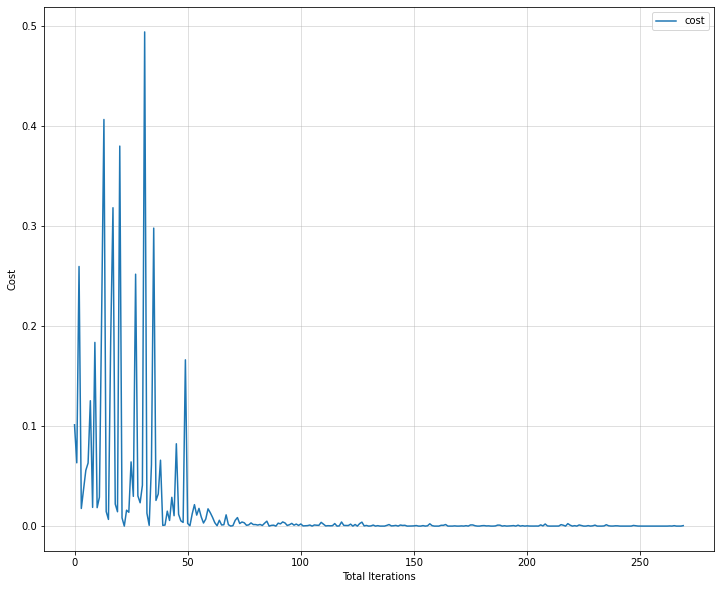

In [ ]:
plt.figure(figsize=(12,10))
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(len(cost)), cost, label='cost')
# plt.plot(np.arange(len(train_acc)), train_acc, label='train_acc')
# plt.plot(np.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid(alpha=0.5)
plt.legend()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/siamese-orl-loss on 30classes')
plt.show()

In [ ]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
n = (apn[0] - apn[2]).pow(2).sum(-1)

In [ ]:
p.max() , p.mean() , n.max(), n.mean()


(tensor(1.4231, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.8647, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(7.3217, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(3.6133, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
sample = torch.cat([model.semi_forward(dataset[i][0].unsqueeze(0).cuda()) for i in tqdm(range(40))])


100%|██████████| 40/40 [00:00<00:00, 874.40it/s]


In [ ]:
sample.device


device(type='cuda', index=0)

In [ ]:
sample.shape


torch.Size([40, 128])

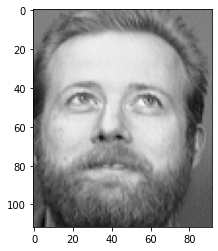

In [ ]:
Class = 0
randImg = dataset[Class][0]
plt.imshow(randImg.squeeze(), cmap='gray')
renc = model.semi_forward(randImg.unsqueeze(0).cuda())

In [ ]:
dis = dist(renc, sample)
dis.argmin(), dis

(tensor(0, device='cuda:0'),
 tensor([0.0000, 2.4852, 5.5270, 1.8431, 3.0656, 2.3418, 1.2660, 1.8373, 1.8809,
         1.3492, 4.8949, 2.2838, 2.6625, 5.1208, 2.6684, 1.6107, 3.4180, 3.6100,
         2.4952, 2.0669, 4.9787, 1.1611, 2.1805, 4.6542, 4.1450, 3.9852, 4.3040,
         2.1565, 3.0525, 2.9782, 2.4489, 1.6495, 2.6570, 1.9603, 1.3391, 2.6215,
         2.7621, 2.2655, 6.1738, 1.0774], device='cuda:0'))

In [ ]:
renc


tensor([[ 0.1448, -0.0399, -0.5426,  0.0916,  0.2374, -0.3261, -0.4788, -0.0273,
         -0.7106,  0.2707,  0.8042, -0.3076, -0.4545,  0.1558, -0.2263,  0.0270,
         -0.4494,  0.4184,  0.2964, -0.1096,  0.2609, -0.2009,  0.1485, -0.7664,
         -0.3512,  0.1075,  0.2969, -0.0733,  0.1780, -0.2396,  0.0896,  0.4529,
         -0.5653,  0.4935,  0.0040, -0.4337, -0.4841, -0.1890,  0.4240,  0.1784,
          0.1031,  0.2777,  0.1792,  0.0376, -0.1993, -0.5251,  0.3861,  0.2203,
         -0.4577, -0.3200,  0.1832,  0.1937, -0.0062,  0.0906,  0.6730,  0.1465,
         -0.1673,  0.3216,  0.1639,  0.5662, -0.2152, -0.0341,  0.0590,  0.3524,
          0.5156, -0.4711,  0.0957, -0.4234,  0.2156,  0.2359,  0.3063,  0.1152,
          1.2758,  0.1220,  0.1210, -0.1754, -0.5689,  0.4966, -0.2213,  0.4086,
         -0.1332,  0.2767, -0.6595,  0.0866,  0.0851, -0.2307, -0.4585,  0.2522,
         -0.2240,  0.1882, -0.0840, -0.2600,  0.0712, -0.7458,  0.1871, -0.2566,
         -0.3060, -0.2350, -

In [ ]:
sample[0]


tensor([ 0.1448, -0.0399, -0.5426,  0.0916,  0.2374, -0.3261, -0.4788, -0.0273,
        -0.7106,  0.2707,  0.8042, -0.3076, -0.4545,  0.1558, -0.2263,  0.0270,
        -0.4494,  0.4184,  0.2964, -0.1096,  0.2609, -0.2009,  0.1485, -0.7664,
        -0.3512,  0.1075,  0.2969, -0.0733,  0.1780, -0.2396,  0.0896,  0.4529,
        -0.5653,  0.4935,  0.0040, -0.4337, -0.4841, -0.1890,  0.4240,  0.1784,
         0.1031,  0.2777,  0.1792,  0.0376, -0.1993, -0.5251,  0.3861,  0.2203,
        -0.4577, -0.3200,  0.1832,  0.1937, -0.0062,  0.0906,  0.6730,  0.1465,
        -0.1673,  0.3216,  0.1639,  0.5662, -0.2152, -0.0341,  0.0590,  0.3524,
         0.5156, -0.4711,  0.0957, -0.4234,  0.2156,  0.2359,  0.3063,  0.1152,
         1.2758,  0.1220,  0.1210, -0.1754, -0.5689,  0.4966, -0.2213,  0.4086,
        -0.1332,  0.2767, -0.6595,  0.0866,  0.0851, -0.2307, -0.4585,  0.2522,
        -0.2240,  0.1882, -0.0840, -0.2600,  0.0712, -0.7458,  0.1871, -0.2566,
        -0.3060, -0.2350, -0.0726, -0.08

In [ ]:
model.semi_forward(dataset[0][0].unsqueeze(0).cuda())


tensor([[ 0.1448, -0.0399, -0.5426,  0.0916,  0.2374, -0.3261, -0.4788, -0.0273,
         -0.7106,  0.2707,  0.8042, -0.3076, -0.4545,  0.1558, -0.2263,  0.0270,
         -0.4494,  0.4184,  0.2964, -0.1096,  0.2609, -0.2009,  0.1485, -0.7664,
         -0.3512,  0.1075,  0.2969, -0.0733,  0.1780, -0.2396,  0.0896,  0.4529,
         -0.5653,  0.4935,  0.0040, -0.4337, -0.4841, -0.1890,  0.4240,  0.1784,
          0.1031,  0.2777,  0.1792,  0.0376, -0.1993, -0.5251,  0.3861,  0.2203,
         -0.4577, -0.3200,  0.1832,  0.1937, -0.0062,  0.0906,  0.6730,  0.1465,
         -0.1673,  0.3216,  0.1639,  0.5662, -0.2152, -0.0341,  0.0590,  0.3524,
          0.5156, -0.4711,  0.0957, -0.4234,  0.2156,  0.2359,  0.3063,  0.1152,
          1.2758,  0.1220,  0.1210, -0.1754, -0.5689,  0.4966, -0.2213,  0.4086,
         -0.1332,  0.2767, -0.6595,  0.0866,  0.0851, -0.2307, -0.4585,  0.2522,
         -0.2240,  0.1882, -0.0840, -0.2600,  0.0712, -0.7458,  0.1871, -0.2566,
         -0.3060, -0.2350, -

In [ ]:
model.semi_forward(dataset[0].cuda())[0]


tensor([ 0.0990, -0.0656, -0.5216,  0.0893,  0.3054, -0.3207, -0.4283, -0.0439,
        -0.6599,  0.2642,  0.7645, -0.2556, -0.4409,  0.1833, -0.2206,  0.0608,
        -0.3695,  0.4170,  0.2920, -0.1149,  0.3234, -0.1763,  0.1087, -0.6943,
        -0.3557,  0.0838,  0.2669, -0.0606,  0.1957, -0.2395,  0.0755,  0.4050,
        -0.5374,  0.4696, -0.0072, -0.4600, -0.4399, -0.1582,  0.3977,  0.2066,
         0.0327,  0.2107,  0.1701,  0.0496, -0.2357, -0.4884,  0.3157,  0.2243,
        -0.4825, -0.3090,  0.1519,  0.1729, -0.0112,  0.0555,  0.6401,  0.1452,
        -0.1559,  0.2669,  0.1675,  0.5993, -0.1999, -0.0643,  0.0521,  0.4112,
         0.4606, -0.4671,  0.1165, -0.4274,  0.1472,  0.2229,  0.2869,  0.0813,
         1.2140,  0.1154,  0.0958, -0.1668, -0.6180,  0.4908, -0.1860,  0.3495,
        -0.0640,  0.2953, -0.6725,  0.0767,  0.0950, -0.2475, -0.4634,  0.2136,
        -0.1991,  0.2051, -0.0626, -0.2362,  0.0792, -0.7086,  0.1776, -0.2701,
        -0.2701, -0.2346, -0.1097, -0.05

In [ ]:
total_enc = [model.semi_forward(dataset[i].cuda()) for i in tqdm(range(40))]


100%|██████████| 40/40 [00:00<00:00, 198.66it/s]


In [ ]:
total_enc[0][0]


tensor([ 0.0990, -0.0656, -0.5216,  0.0893,  0.3054, -0.3207, -0.4283, -0.0439,
        -0.6599,  0.2642,  0.7645, -0.2556, -0.4409,  0.1833, -0.2206,  0.0608,
        -0.3695,  0.4170,  0.2920, -0.1149,  0.3234, -0.1763,  0.1087, -0.6943,
        -0.3557,  0.0838,  0.2669, -0.0606,  0.1957, -0.2395,  0.0755,  0.4050,
        -0.5374,  0.4696, -0.0072, -0.4600, -0.4399, -0.1582,  0.3977,  0.2066,
         0.0327,  0.2107,  0.1701,  0.0496, -0.2357, -0.4884,  0.3157,  0.2243,
        -0.4825, -0.3090,  0.1519,  0.1729, -0.0112,  0.0555,  0.6401,  0.1452,
        -0.1559,  0.2669,  0.1675,  0.5993, -0.1999, -0.0643,  0.0521,  0.4112,
         0.4606, -0.4671,  0.1165, -0.4274,  0.1472,  0.2229,  0.2869,  0.0813,
         1.2140,  0.1154,  0.0958, -0.1668, -0.6180,  0.4908, -0.1860,  0.3495,
        -0.0640,  0.2953, -0.6725,  0.0767,  0.0950, -0.2475, -0.4634,  0.2136,
        -0.1991,  0.2051, -0.0626, -0.2362,  0.0792, -0.7086,  0.1776, -0.2701,
        -0.2701, -0.2346, -0.1097, -0.05

In [ ]:
pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
print(*pred, sep='\n')

tensor([0, 0, 9, 9, 0, 0, 9, 9, 9, 9], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([3, 9, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([ 4,  4,  4,  4,  4, 11,  4,  4,  4,  4], device='cuda:0')
tensor([ 5,  5,  5,  5,  5, 33, 32,  5,  5,  5], device='cuda:0')
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0')
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
tensor([10, 10, 20,  3, 10, 10, 10, 10, 10, 10], device='cuda:0')
tensor([11, 11, 33, 11, 11, 11, 11, 11, 11, 33], device='cuda:0')
tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12], device='cuda:0')
tensor([13, 20, 36, 13, 20, 13, 13, 20, 13, 20], device='cuda:0')
tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14], device='cuda:0')
tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15], device='cuda:0')
tensor([16, 14, 38, 16, 

In [ ]:
sum([(pred[i] == i).sum() for i in range(0,30)]) / 300


tensor(0.8533, device='cuda:0')

In [ ]:
tc = []
for i in range(0,40):
    corr = (pred[i] == i).sum()
    print(f'(Claas {i})', corr.item(), 'out of 10')
    tc.append(corr.item())

print('Train Accuracy = ', sum(tc[:30])/3, '%')
print('Test Accuracy = ', sum(tc[30:])/1, '%')
print('Total Accuracy = ', sum(tc)/4, '%')

(Claas 0) 4 out of 10
(Claas 1) 10 out of 10
(Claas 2) 10 out of 10
(Claas 3) 9 out of 10
(Claas 4) 9 out of 10
(Claas 5) 8 out of 10
(Claas 6) 10 out of 10
(Claas 7) 10 out of 10
(Claas 8) 10 out of 10
(Claas 9) 10 out of 10
(Claas 10) 8 out of 10
(Claas 11) 8 out of 10
(Claas 12) 10 out of 10
(Claas 13) 5 out of 10
(Claas 14) 10 out of 10
(Claas 15) 10 out of 10
(Claas 16) 4 out of 10
(Claas 17) 6 out of 10
(Claas 18) 7 out of 10
(Claas 19) 7 out of 10
(Claas 20) 9 out of 10
(Claas 21) 10 out of 10
(Claas 22) 5 out of 10
(Claas 23) 10 out of 10
(Claas 24) 9 out of 10
(Claas 25) 10 out of 10
(Claas 26) 10 out of 10
(Claas 27) 9 out of 10
(Claas 28) 9 out of 10
(Claas 29) 10 out of 10
(Claas 30) 8 out of 10
(Claas 31) 5 out of 10
(Claas 32) 10 out of 10
(Claas 33) 10 out of 10
(Claas 34) 7 out of 10
(Claas 35) 4 out of 10
(Claas 36) 7 out of 10
(Claas 37) 4 out of 10
(Claas 38) 6 out of 10
(Claas 39) 8 out of 10
Train Accuracy =  85.33333333333333 %
Test Accuracy =  69.0 %
Total Accura

In [ ]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
        if pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={pred[i][j].item()}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results of all 40 classes.png', dpi=200)
plt.show()

**LFW Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.is_available()

True

In [ ]:
import sklearn
from sklearn import datasets

In [ ]:
lfw_pairs = datasets.fetch_lfw_pairs(
    subset='train',
    data_home="/content/drive/MyDrive/Colab Notebooks/lfw",
    funneled=False,
    resize=1,
    color=True,
    download_if_missing=True
    )
# ref : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_pairs.html

In [ ]:
lfw_pairs.keys()

In [ ]:
pairDevTrain = open("/content/drive/MyDrive/Colab Notebooks/lfw/lfw_home/pairsDevTrain.txt").readlines()[1:]

In [ ]:
index = 99
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [ ]:
lfw_people = datasets.fetch_lfw_people(
    data_home="/content/drive/MyDrive/Colab Notebooks/LFW",
    min_faces_per_person=2,
    resize=1,
    color=True,
    download_if_missing=True
)

In [ ]:
def get_random_triplets(no_classes:int, images, target, no_triplets:int):
    # Ref : https://github.com/tamerthamoqa/facenet-pytorch-vggface2/blob/master/datasets/TripletLossDataset.py#L76-L136
    randomstate = np.random.RandomState(seed=None)
    # no_class = len(lfw_people.target_names)
    triplets = []
    class_pairs = []

    ###
    # _,axxar = plt.subplots(no_triplets,3, figsize=(7,5))
    # plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    # # ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
    ###

    # progress_bar = tqdm(range(no_triplets), desc='fetching triplets')
    for progress in range(no_triplets):

        pos_class = randomstate.choice(no_classes)
        neg_class = randomstate.choice(no_classes)
        while pos_class == neg_class:
            neg_class = randomstate.choice(no_classes)

        # pos_name = lfw_people.target_names[pos_class]
        # neg_name = lfw_people.target_names[neg_class]

        pos_imgs = images[target == pos_class]
        neg_imgs = images[target == neg_class]

        if pos_imgs.shape[0] == 2:
            ianc, ipos = 0,1
        else:
            ianc = randomstate.randint(0, pos_imgs.shape[0])
            ipos = randomstate.randint(0, pos_imgs.shape[0])
            while ianc == ipos:
                ipos = randomstate.randint(0, pos_imgs.shape[0])
        ineg = randomstate.randint(0, neg_imgs.shape[0])

        ####
        # axxar[progress][0].imshow(pos_imgs[ianc] / 255)
        # axxar[progress][0].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][1].imshow(pos_imgs[ipos] / 255)
        # axxar[progress][1].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][2].imshow(neg_imgs[ineg] / 255)
        # axxar[progress][2].set_title(lfw_people.target_names[neg_class])
        ####

        triplets.append(
            torch.stack([
                torch.from_numpy(pos_imgs[ianc] / 255),
                torch.from_numpy(pos_imgs[ipos] / 255),
                torch.from_numpy(neg_imgs[ineg] / 255)
            ]))
        class_pairs.append((pos_class, neg_class))

    return torch.stack(triplets) , class_pairs

In [ ]:
class ResModel(nn.Module):
    def __init__(self):
        super(ResModel, self).__init__()
        # use the following line for Sqeezenet
        self.resnet = torchvision.models.squeezenet1_0()
        # use the following line for the resnet
        #self.resnet = torchvision.models.resnet18()
        self.linear = nn.Linear(1000, 128)

    def semi_forward(self,x):
        x = self.resnet(x)
        x = self.linear(x)
        return x

    def forward(self, triplet):
        triplet = triplet.movedim(-1, -3)
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]
#   Contrastive loss
#    def forward(self, pairs):
#        pairs = pairs.movedim(-1, -3)
#        first = self.semi_forward(pairs[:,0,...])
#        second = self.semi_forward(pairs[:,1,...])
#        return [first, second]

In [ ]:
model = ResModel()

In [ ]:
lfw_pairs.pairs[:1100].shape

In [ ]:
model = model.cuda()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfn = nn.TripletMarginLoss(margin=1, reduction='mean')


In [ ]:
cost = []

epochs = 1000
for epoch in range(epochs):

    triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names),
                                                images=lfw_people.images,
                                                target=lfw_people.target, no_triplets=500)

    apn = model(triplets.cuda())
    # apn = model(triplets)

    optimizer.zero_grad()
    #loss = triplet_loss(*apn)
    loss = lossfn(*apn)
    cost.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')

**Contrastive** **loss**

In [ ]:
class ResModel(nn.Module):
    def __init__(self):
        super(ResModel, self).__init__()
        # use the following line for Sqeezenet
        self.resnet = torchvision.models.squeezenet1_0()
        # use the following line for the resnet
        #self.resnet = torchvision.models.resnet18()
        self.linear = nn.Linear(1000, 128)

    def semi_forward(self,x):
        x = self.resnet(x)
        x = self.linear(x)
        return x

#    def forward(self, triplet):
#        triplet = triplet.movedim(-1, -3)
#        anc = self.semi_forward(triplet[:,0,...])
#        pos = self.semi_forward(triplet[:,1,...])
#        neg = self.semi_forward(triplet[:,2,...])
#        return [anc, pos, neg]
#   Contrastive loss
    def forward(self, pairs):
        pairs = pairs.movedim(-1, -3)
        first = self.semi_forward(pairs[:,0,...])
        second = self.semi_forward(pairs[:,1,...])
        return [first, second]

The problem we encountered here is to load the data and it's labels, we could load the data itself but not the labels.

In [ ]:
bs = 64
dataset_loader_train = torch.utils.data.DataLoader(torch.tensor(lfw_pairs.pairs), shuffle=False,
                                                  batch_size=bs,
                                                  pin_memory=True)

In [ ]:
len(dataset_loader_train)

35

In [ ]:
def contrastive_loss(first, second, label, margin=1):
    dist = (first - second).pow(2).sum(-1) #.pow(.5)
    same_pair = F.relu(margin - dist)
    loss = label * dist.pow(2) + (1 - label) * same_pair.pow(2)
    return loss.mean()

In [ ]:
cost = []
epochs = 1000
i = 0
for epoch in range(epochs):

  for i, data in enumerate(dataset_loader_train, 0):


SyntaxError: ignored

In [ ]:
cost = []
dataset = torch.tensor(lfw_pairs.pairs)
epochs = 1000
i = 0
for epoch in range(epochs):
    loader = torch.utils.data.DataLoader(dataset , batch_size=1)
    for sample in loader:
#      fir = sample[:,0,...] /255
#      sec = sample[:,1,...] /255
#      sample[:,0,...].cuda() /255
#      pairs = torch.stack([fir, sec])
      fs = model(sample.cuda() /255)
      # apn = model(triplets)

      optimizer.zero_grad()
      #loss = triplet_loss(*apn)
      print((torch.reshape(torch.tensor(lfw_pairs.target[i]),(1,))).ndim)
      loss = loss_func(*fs,(torch.reshape(torch.tensor(lfw_pairs.target[i]),(1,))))
      cost.append(loss.item())

      loss.backward()
      optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')

In [ ]:
!nvidia-smi

In [ ]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs), cost)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)

In [ ]:
loader = torch.utils.data.DataLoader(lfw_pairs.pairs, batch_size=1)

In [ ]:
lfw_pairs.pairs.shape

In [ ]:
len(loader)

In [ ]:
sample = next(iter(loader))
sample.shape

In [ ]:
pred = []

In [ ]:
for sample in loader:
    test1 = sample[:,0,...].cuda() /255
    test2 = sample[:,1,...].cuda() /255
    enc1 = model.semi_forward(test1.movedim(-1,-3))
    enc2 = model.semi_forward(test2.movedim(-1,-3))
    d = dist(enc1,enc2)
    pred.append(d.cpu().detach().numpy())

In [ ]:
min = 100
max = 0
for i in range(1100):
  if pred[i+1000][0] > max:
    max = pred[i][0]
  if pred[i+1100][0] < min:
    min = pred[i][0]

In [ ]:
min

In [ ]:
correct = np.zeros((1,1106))
for i in range(98,1203):
  threshold = i / 100
  correct_positive = 0
  correct_negative = 0
  uncorrect_positive = 0
  uncorrect_negative = 0
  for j in range(1100):
    if  pred[j][0] < threshold:
      correct_positive = correct_positive + 1
    if pred[j+1100][0] > threshold:
      correct_negative = correct_negative + 1
    corr = correct_positive + correct_negative
    correct[0,(i-98)] = corr


In [ ]:
correct

In [ ]:
j = np.zeros((1,1106))
for k in range(98,1203):
  j[0,(k-98)] = k/100

In [ ]:
plt.plot(j[0],correct[0])

In [ ]:
correct_positive = 0
correct_negative = 0
corr = 0
for j in range(1100):
    if  pred[j][0] < 0.69:
      correct_positive = correct_positive + 1
    if pred[j+1100][0] > 0.69:
      correct_negative = correct_negative + 1
    corr = correct_positive + correct_negative

In [ ]:
correct_negative

In [ ]:
correct